In [1]:
!pip install category_encoders==2.*;

In [2]:
!pip install pdpbox

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.inspection import plot_partial_dependence;

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Import Data

In [4]:
#Create wrangle function to load dataset, change Year column to datetime series and set it as the index 
def wrangle(filepath):
  df = pd.read_csv(filepath, parse_dates=['Year'], index_col=['Year'])

  return df

df = wrangle('Medicaid_Chronic_Conditions.csv')

In [5]:
df.head()

,Primary County,Dual Eligible,Major Diagnostic Category,Episode Disease Category,Beneficiaries with Condition,Beneficiaries with Admissions,Total Inpatient Admissions,Beneficiaries with ER Visits,Total ER Visits
Year,,,,,,,,,
2012-01-01,Albany,Dual,Substance Abuse,Cocaine Abuse - Continuous,21,20,53,19,139
2012-01-01,Allegany,Dual,Diabetes Mellitus,Diabetes with Circulatory Complication,21,10,16,10,22
2012-01-01,Allegany,Non-Dual,Diabetes Mellitus,Other Diabetic Complications,21,11,25,15,34
2012-01-01,Allegany,Non-Dual,Substance Abuse,Opioid Abuse - Continuous,21,17,25,17,35
2012-01-01,Cattaraugus,Dual,Diseases And Disorders Of The Cardiovascular S...,Chronic Cardiovascular Diagnoses - Minor,21,15,23,7,29


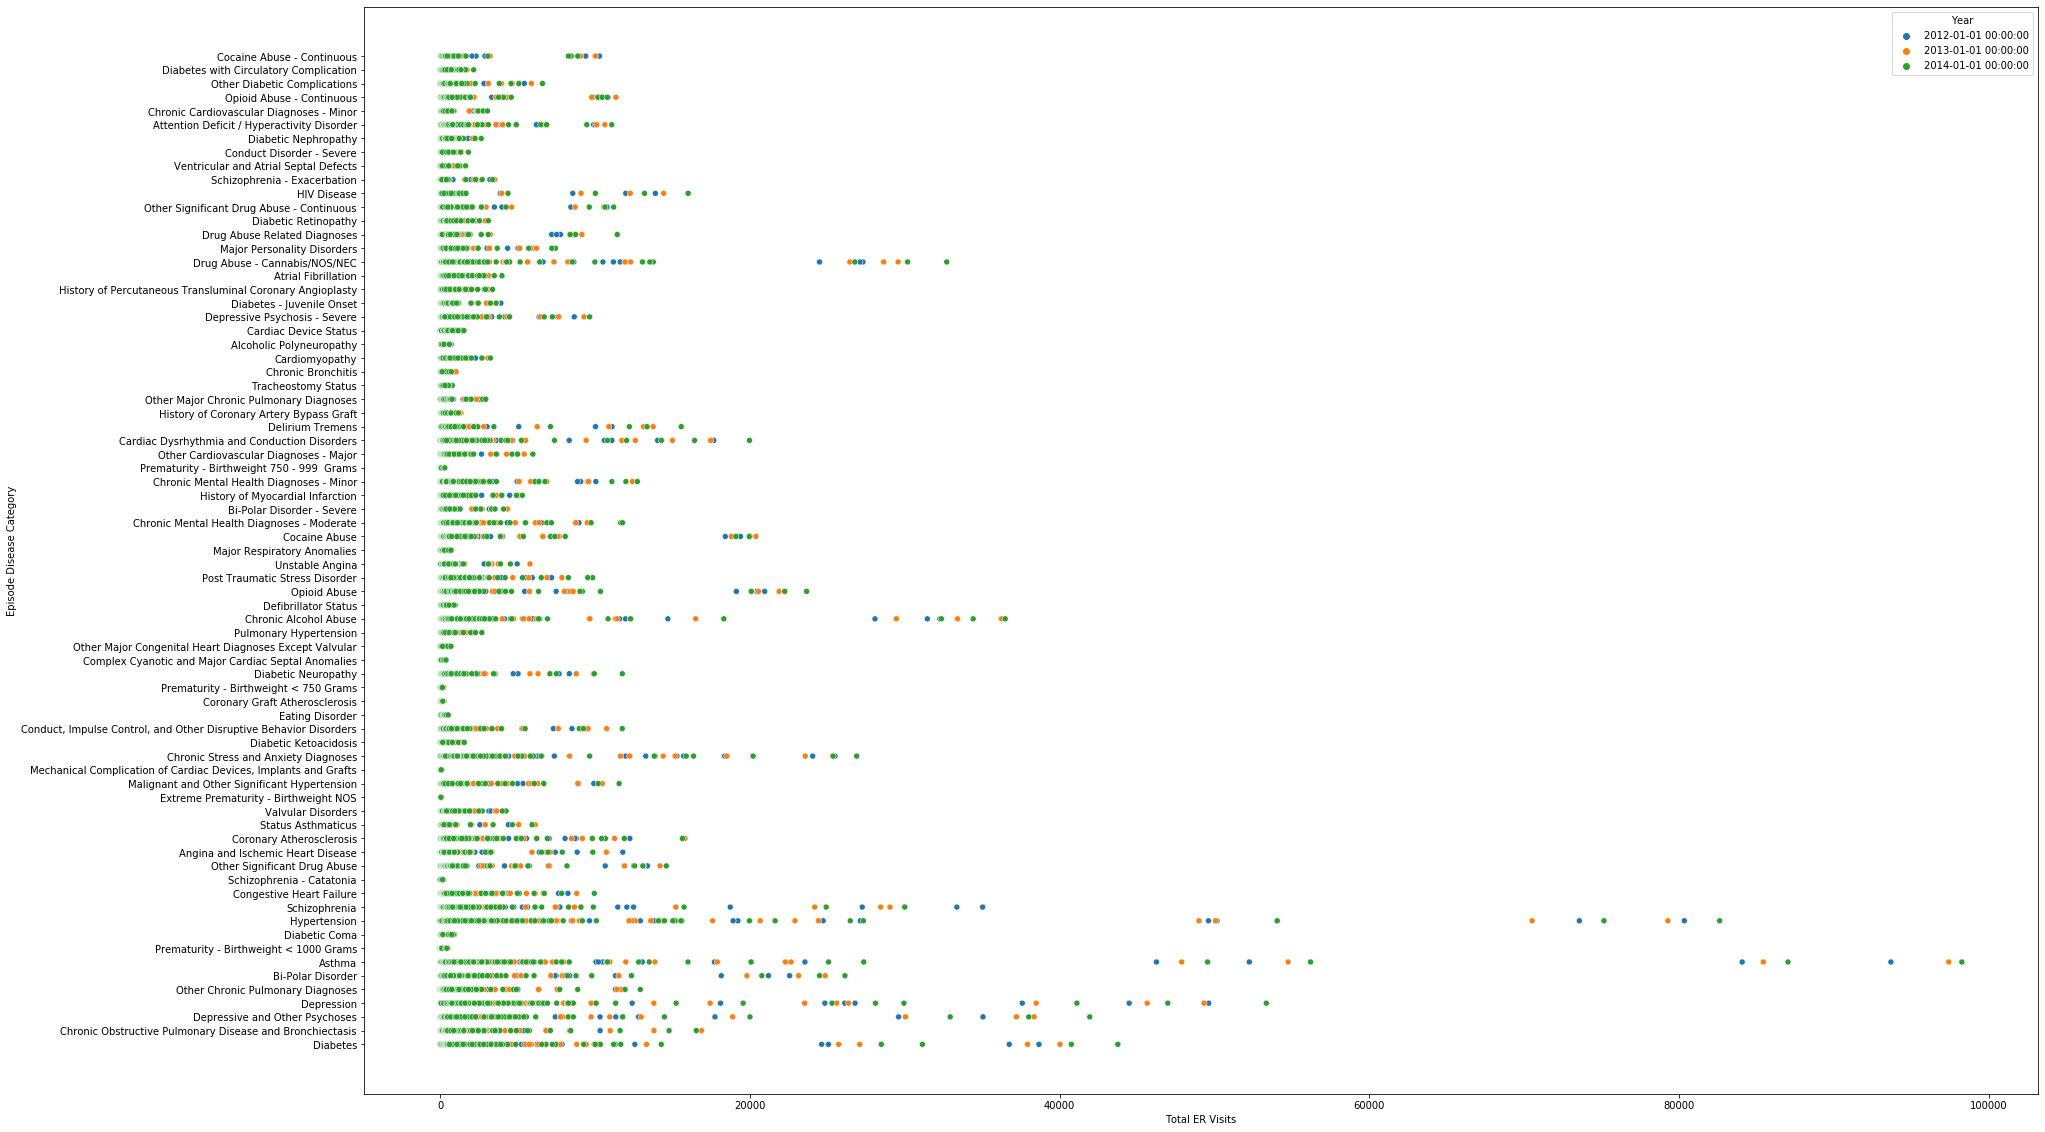

In [6]:
#Initial visualization of information of interest
plt.figure(figsize=(30,20))
sns.scatterplot(x='Total ER Visits', y='Episode Disease Category', data=df, hue='Year', legend='auto')
plt.show()

#Split Dataset

In [7]:
#Separate y variable and X matrix
target='Total ER Visits'
y= df[target]
X= df.drop(columns=target)

print(y.shape)
print(X.shape)

(17046,)
(17046, 8)


In [8]:
#Split training set and remainder set, constrain training set to 2012-2013 data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=.8, random_state=33)
train_threshold = '2013-12-31'
mask = X.index < train_threshold
X_train, y_train = X.loc[mask], y.loc[mask]

#Split remaining dataset into test and validation sets, constrain both to 2014 data 
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=.5, random_state=33)
X_test, y_test = X.loc[~mask], y.loc[~mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

print(X_train.shape), print(y_train.shape) #66.2% 2012-2013
print(X_test.shape), print(y_test.shape) #33.8% 2014 
print(X_val.shape), print(y_val.shape) #33.8% 2014

(11284, 8)
(11284,)
(5762, 8)
(5762,)
(5762, 8)
(5762,)


(None, None)

Baseline Mean Absolute Error

In [9]:
average_ER_visits = y_train.mean()
baseline_pred = [average_ER_visits] * len(y_train)
print("Baseline MAE:", mean_absolute_error(y_train, baseline_pred))

Baseline MAE: 1396.9047403751754


#Modeling

Linear Regression Model

In [10]:
#Linear regression model
model_linr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LinearRegression()
)
model_linr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Primary County', 'Dual Eligible',
                                     'Major Diagnostic Category',
                                     'Episode Disease Category'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

Ridge Regression Model

In [11]:
#Ridge regression model
model_rr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    Ridge(alpha= 1.0, normalize= False)
)
model_rr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Primary County', 'Dual Eligible',
                                     'Major Diagnostic Category',
                                     'Episode Disease Category'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

Decision Tree Regression Model

In [12]:
#Decision Tree regression model
model_dtr = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeRegressor()
)
model_dtr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Primary County', 'Dual Eligible',
                                      'Major Diagnostic Category',
                                      'Episode Disease Category'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Primary County',
                                          'data_type': dtype('O'),
                                          'mapping': Albany          1
Allegany        2
Cattaraugus     3
Chautauqua      4
Chemung         5
               ..
Erie           59
New York       60
Yate...
Length: 74, dtype: int64}],
                                return_df=True, verbose=0)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=None, max_fe

Random Forest Regression Model

In [13]:
#Random Forest regression model
model_rfr = make_pipeline(
    OrdinalEncoder(),
    RandomForestRegressor()
)
model_rfr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Primary County', 'Dual Eligible',
                                      'Major Diagnostic Category',
                                      'Episode Disease Category'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Primary County',
                                          'data_type': dtype('O'),
                                          'mapping': Albany          1
Allegany        2
Cattaraugus     3
Chautauqua      4
Chemung         5
               ..
Erie           59
New York       60
Yate...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       m

XGBoost Regression Model

In [16]:
#XGBoost regression model
model_xgbr = make_pipeline(
    OrdinalEncoder(),
    XGBRegressor()
)
model_xgbr.fit(X_train, y_train)

[13:42:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Primary County', 'Dual Eligible',
                                      'Major Diagnostic Category',
                                      'Episode Disease Category'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Primary County',
                                          'data_type': dtype('O'),
                                          'mapping': Albany          1
Allegany        2
Cattaraugus     3
Chautauqua      4
Chemung         5
               ..
Erie           59
New York       60
Yate...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3,

#Metrics

Mean Absolute Error

In [17]:
model_linr_train_mae = mean_absolute_error(y_train, model_linr.predict(X_train))
model_linr_val_mae = mean_absolute_error(y_val, model_linr.predict(X_val))

model_rr_train_mae = mean_absolute_error(y_train, model_rr.predict(X_train))
model_rr_val_mae = mean_absolute_error(y_val, model_rr.predict(X_val))

model_dtr_train_mae = mean_absolute_error(y_train, model_dtr.predict(X_train))
model_dtr_val_mae = mean_absolute_error(y_val, model_dtr.predict(X_val))

model_rfr_train_mae = mean_absolute_error(y_train, model_rfr.predict(X_train))
model_rfr_val_mae = mean_absolute_error(y_val, model_rfr.predict(X_val))

model_xgbr_train_mae = mean_absolute_error(y_train, model_xgbr.predict(X_train))
model_xgbr_val_mae = mean_absolute_error(y_val, model_xgbr.predict(X_val))

print('\033[1m''Linear Regression Model''\033[0m')
print('Training MAE:', model_linr_train_mae)
print('Validation MAE:', model_linr_val_mae)
print()
print('\033[1m''Ridge Regression Model''\033[0m')
print('Training MAE:', model_rr_train_mae)
print('Validation MAE:', model_rr_val_mae)
print()
print('\033[1m''Decision Tree Regression Model''\033[0m')
print('Training MAE:', model_dtr_train_mae)
print('Validation MAE:', model_dtr_val_mae)
print()
print('\033[1m''Random Forest Regression Model''\033[0m')
print('Training MAE:', model_rfr_train_mae)
print('Validation MAE:', model_rfr_val_mae)
print()
print('\033[1m''XGBoost Regression Model''\033[0m')
print('Training MAE:', model_xgbr_train_mae)
print('Validation MAE:', model_xgbr_val_mae)

Linear Regression Model
Training MAE: 165.6000915846329
Validation MAE: 183.64321895438368

Ridge Regression Model
Training MAE: 165.5106992137187
Validation MAE: 183.61933092213187

Decision Tree Regression Model
Training MAE: 0.0
Validation MAE: 166.77542519958348

Random Forest Regression Model
Training MAE: 42.66858383551932
Validation MAE: 125.60608642832351

XGBoost Regression Model
Training MAE: 117.74297094448625
Validation MAE: 152.90383644484265


#Model Tuning

Random Forest Regression Model

Cross-validation

In [20]:
#Cross-validation using X and y
cv_scores_rfr = cross_val_score(model_rfr, X, y, cv=5, n_jobs=-1)

print('Cross-validation Scores:', cv_scores_rfr)
print('Validation Accuracy:', cv_scores_rfr.mean())

Cross-validation Scores: [0.99218385 0.99296625 0.94279653 0.99323842 0.98930253]
Validation Accuracy: 0.9820975176085998


In [21]:
#Cross-validation using X_train and y_train
cv_scores_rfr_train = cross_val_score(model_rfr, X_train, y_train, cv=5, n_jobs=-1)

print('Cross-validation Scores:', cv_scores_rfr_train)
print('Validation Accuracy:', cv_scores_rfr_train.mean())

Cross-validation Scores: [0.99512193 0.93502534 0.9883693  0.85521094 0.98302297]
Validation Accuracy: 0.951350098616541


In [24]:
#Mean absolute error comparison
cv_scores_mae = mean_absolute_error(y, model_rfr.predict(X))
cv_scores_val_mae = mean_absolute_error(y_val, model_rfr.predict(X_val))

cv_scores_train_mae = mean_absolute_error(y_train, model_rfr.predict(X_train))
cv_scores_train_val_mae = mean_absolute_error(y_val, model_rfr.predict(X_val))

print('\033[1m''Cross-validation MAE - X/y''\033[0m')
print('Training MAE:', cv_scores_mae)
print('Validation MAE:', cv_scores_val_mae)
print()
print('\033[1m''Cross-validation MAE - X_train/y_train''\033[0m')
print('Training MAE:', cv_scores_train_mae)
print('Validation MAE:', cv_scores_train_val_mae)

Cross-validation MAE - X/y
Training MAE: 70.70365892291446
Validation MAE: 125.60608642832351

Cross-validation MAE - X_train/y_train
Training MAE: 42.66858383551932
Validation MAE: 125.60608642832351


In [29]:
#Testing hyperparameters individually out of curiosity
model_rfr_ind = make_pipeline(
    OrdinalEncoder(),
    RandomForestRegressor(max_depth=21, max_leaf_nodes=5000, n_estimators=110)
)
model_rfr_ind.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Primary County', 'Dual Eligible',
                                      'Major Diagnostic Category',
                                      'Episode Disease Category'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Primary County',
                                          'data_type': dtype('O'),
                                          'mapping': Albany          1
Allegany        2
Cattaraugus     3
Chautauqua      4
Chemung         5
               ..
Erie           59
New York       60
Yate...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=21,
                                       max_features='auto', max_leaf_nodes=5000,
                                       max

In [30]:
model_rfr_ind_mae = mean_absolute_error(y_train, model_rfr_ind.predict(X_train))
model_rfr_ind_val_mae = mean_absolute_error(y_val, model_rfr_ind.predict(X_val))

print('\033[1m''Random Forest Regression Model - Tuning Hyperparameters Individually''\033[0m')
print('Training MAE:', model_rfr_ind_mae)
print('Validation MAE:', model_rfr_ind_val_mae)

Random Forest Regression Model - Tuning Hyperparameters Individually
Training MAE: 42.78445834025957
Validation MAE: 125.89953438048947


GridSearchCV Model

In [31]:
model_rfr.named_steps

{'ordinalencoder': OrdinalEncoder(cols=['Primary County', 'Dual Eligible',
                      'Major Diagnostic Category', 'Episode Disease Category'],
                drop_invariant=False, handle_missing='value',
                handle_unknown='value',
                mapping=[{'col': 'Primary County', 'data_type': dtype('O'),
                          'mapping': Albany          1
 Allegany        2
 Cattaraugus     3
 Chautauqua      4
 Chemung         5
                ..
 Erie           59
 New York       60
 Yates          61
 Queens         62
 NaN            -2
 Length: 63, dtype: int64},
                         {'col':...
                         {'col': 'Episode Disease Category',
                          'data_type': dtype('O'),
                          'mapping': Cocaine Abuse - Continuous                                   1
 Diabetes with Circulatory Complication                       2
 Other Diabetic Complications                                 3
 Opioid Abuse - Co

In [32]:
#After experimenting with many hyperparameter options, I've chosen these as most likely to provide the greatest accuracy
param_grid = {
    'randomforestregressor__max_depth': [30, 35],
    'randomforestregressor__max_leaf_nodes': [55, 60],
    'randomforestregressor__min_samples_leaf': [0, 1],
    'randomforestregressor__min_samples_split': [1, 2]  
}

In [33]:
model_rfr_gscv = GridSearchCV(model_rfr, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)

model_rfr_gscv.fit(X, y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   22.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['Primary County',
                                                             'Dual Eligible',
                                                             'Major Diagnostic '
                                                             'Category',
                                                             'Episode Disease '
                                                             'Category'],
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=[{'col': 'Primary '
                                                                        'Count

In [34]:
print('Best Score:', model_rfr_gscv.best_score_)
from IPython.display import HTML
display(HTML('''
<style>
  pre {
      white-space: normal;
  }
</style>
'''))
print('Best Parameters:', model_rfr_gscv.best_params_)

Best Score: 0.9892330761481302


Best Parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_leaf_nodes': 60, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2}


#Best Model Fitting

Training Dataset

In [53]:
#After trying various n_estimators values, I've determined the best one to use in my pipeline
model_rfr_train = make_pipeline(
    OrdinalEncoder(),
    RandomForestRegressor(max_depth=30, max_leaf_nodes=60, n_estimators=90)
)
model_rfr_train.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Primary County', 'Dual Eligible',
                                      'Major Diagnostic Category',
                                      'Episode Disease Category'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Primary County',
                                          'data_type': dtype('O'),
                                          'mapping': Albany          1
Allegany        2
Cattaraugus     3
Chautauqua      4
Chemung         5
               ..
Erie           59
New York       60
Yate...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=30,
                                       max_features='auto', max_leaf_nodes=60,
                                       max_s

In [54]:
model_rfr_t_mae = mean_absolute_error(y_train, model_rfr_train.predict(X_train))
model_rfr_t_val_mae = mean_absolute_error(y_val, model_rfr_train.predict(X_val))

print('\033[1m''Tuned Random Forest Regression Model - Training Dataset''\033[0m')
print('Training MAE:', model_rfr_t_mae)
print('Validation MAE:', model_rfr_t_val_mae)
print('_________________________________________________________')
print()
print('\033[1m''Untuned Random Forest Regression Model - Training Dataset''\033[0m')
print('Training MAE:', model_rfr_train_mae)
print('Validation MAE:', model_rfr_val_mae)

Tuned Random Forest Regression Model - Training Dataset
Training MAE: 133.5644865161256
Validation MAE: 170.03910211279603
_________________________________________________________

Untuned Random Forest Regression Model - Training Dataset
Training MAE: 42.66858383551932
Validation MAE: 125.60608642832351


Testing Dataset

In [56]:
model_rfr_test = make_pipeline(
    OrdinalEncoder(),
    RandomForestRegressor(max_depth=30, max_leaf_nodes=60, n_estimators=90)
)
model_rfr_test.fit(X_test, y_test)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Primary County', 'Dual Eligible',
                                      'Major Diagnostic Category',
                                      'Episode Disease Category'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Primary County',
                                          'data_type': dtype('O'),
                                          'mapping': Orange       1
Warren       2
Saratoga     3
Broome       4
Dutchess     5
            ..
Richmond    59
Sullivan    60
Monroe      6...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=30,
                                       max_features='auto', max_leaf_nodes=60,
                                       max_samples=None,
  

In [57]:
model_rfr_test_mae = mean_absolute_error(y_test, model_rfr_test.predict(X_test))
model_rfr_test_val_mae = mean_absolute_error(y_val, model_rfr_test.predict(X_val))

print('\033[1m''Tuned Random Forest Regression Model - Testing Dataset''\033[0m')
print('Testing MAE:', model_rfr_test_mae)
print('Validation MAE:', model_rfr_test_val_mae)
print('_______________________________________________________')
print()
print('\033[1m''Tuned Random Forest Regression Model - Training Dataset''\033[0m')
print('Training MAE:', model_rfr_t_mae)
print('Validation MAE:', model_rfr_t_val_mae)
print()
print('\033[1m''Untuned Random Forest Regression Model - Training Dataset''\033[0m')
print('Training MAE:', model_rfr_train_mae)
print('Validation MAE:', model_rfr_val_mae)

Tuned Random Forest Regression Model - Testing Dataset
Testing MAE: 145.59359135415173
Validation MAE: 145.59359135415173
_______________________________________________________

Tuned Random Forest Regression Model - Training Dataset
Training MAE: 133.5644865161256
Validation MAE: 170.03910211279603

Untuned Random Forest Regression Model - Training Dataset
Training MAE: 42.66858383551932
Validation MAE: 125.60608642832351


#Visualization

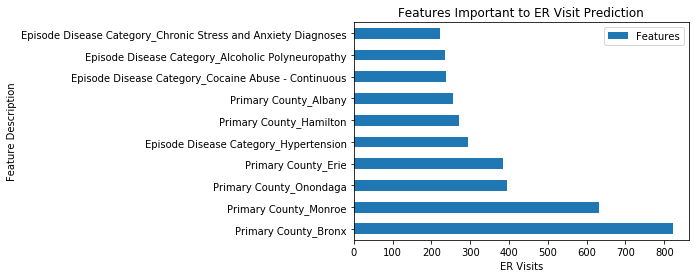

In [58]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X)
XT_train = ohe.transform(X_train)

model_rfrv = Ridge()
model_rfrv.fit(XT_train, y_train)

slopes = pd.DataFrame(data=model_rfrv.coef_, index= XT_train.columns, columns=['Features'])
slopes.abs().sort_values(by='Features', ascending=False).head(10).plot(kind='barh')
plt.title("Features Important to ER Visit Prediction")
plt.xlabel("ER Visits")
plt.ylabel("Feature Description")
plt.show()

#Model Building Using Specific Columns of Dataset

Import dataset

In [59]:
def wrangle(filepath):
  df = pd.read_csv(filepath, parse_dates=['Year'], index_col=['Year'])

  return df

df = wrangle('Medicaid_Chronic_Conditions.csv')

In [60]:
df.head()

,Primary County,Dual Eligible,Major Diagnostic Category,Episode Disease Category,Beneficiaries with Condition,Beneficiaries with Admissions,Total Inpatient Admissions,Beneficiaries with ER Visits,Total ER Visits
Year,,,,,,,,,
2012-01-01,Albany,Dual,Substance Abuse,Cocaine Abuse - Continuous,21,20,53,19,139
2012-01-01,Allegany,Dual,Diabetes Mellitus,Diabetes with Circulatory Complication,21,10,16,10,22
2012-01-01,Allegany,Non-Dual,Diabetes Mellitus,Other Diabetic Complications,21,11,25,15,34
2012-01-01,Allegany,Non-Dual,Substance Abuse,Opioid Abuse - Continuous,21,17,25,17,35
2012-01-01,Cattaraugus,Dual,Diseases And Disorders Of The Cardiovascular S...,Chronic Cardiovascular Diagnoses - Minor,21,15,23,7,29


In [61]:
#I'm most interested in learning which condition categories result in higher numbers of ER visits so I'll drop columns that seem unrelated.
cols_to_drop = ['Primary County', 'Dual Eligible', 'Major Diagnostic Category']
df.drop(columns=cols_to_drop, axis=1, inplace=True)
df.head()

,Episode Disease Category,Beneficiaries with Condition,Beneficiaries with Admissions,Total Inpatient Admissions,Beneficiaries with ER Visits,Total ER Visits
Year,,,,,,
2012-01-01,Cocaine Abuse - Continuous,21,20,53,19,139
2012-01-01,Diabetes with Circulatory Complication,21,10,16,10,22
2012-01-01,Other Diabetic Complications,21,11,25,15,34
2012-01-01,Opioid Abuse - Continuous,21,17,25,17,35
2012-01-01,Chronic Cardiovascular Diagnoses - Minor,21,15,23,7,29


Split dataset

In [62]:
#Separate y variable and X matrix
target='Total ER Visits'
y= df[target]
X= df.drop(columns=target)

print(y.shape)
print(X.shape)

(17046,)
(17046, 5)


In [63]:
#Split training set and remainder set, constrain training set to 2012-2013 data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=.8, random_state=33)
train_threshold = '2013-12-31'
mask = X.index < train_threshold
X_train, y_train = X.loc[mask], y.loc[mask]

#Split remaining dataset into test and validation sets, constrain both to 2014 data 
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=.5, random_state=33)
X_test, y_test = X.loc[~mask], y.loc[~mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

print(X_train.shape), print(y_train.shape) #66.2% 2012-2013
print(X_test.shape), print(y_test.shape) #33.8% 2014 
print(X_val.shape), print(y_val.shape) #33.8% 2014

(11284, 5)
(11284,)
(5762, 5)
(5762,)
(5762, 5)
(5762,)


(None, None)

Modeling

In [64]:
#Random Forest regression model
model_excol = make_pipeline(
    OrdinalEncoder(),
    RandomForestRegressor()
)
model_excol.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Episode Disease Category'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Episode Disease Category',
                                          'data_type': dtype('O'),
                                          'mapping': Cocaine Abuse - Continuous                                   1
Diabetes with Circulatory Complication                       2
Other Diabetic Complications                                 3
Opioid Abuse - Continuous                                    4
Chroni...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
   

Metrics

In [65]:
cv_scores_excol = cross_val_score(model_excol, X, y, cv=5, n_jobs=-1)

print('\033[1m''Columns Excluded Model Cross-validation MAE''\033[0m')
print('Cross-validation Scores:', cv_scores_excol)
print('Validation Accuracy:', cv_scores_excol.mean())
print()
print('\033[1m''Original Model Cross-validation MAE''\033[0m')
print('Cross-validation Scores:', cv_scores_rfr)
print('Validation Accuracy:', cv_scores_rfr.mean())

Columns Excluded Model Cross-validation MAE
Cross-validation Scores: [0.99073499 0.9928487  0.93493633 0.99231756 0.9865733 ]
Validation Accuracy: 0.9794821782572332

Original Model Cross-validation MAE
Cross-validation Scores: [0.99218385 0.99296625 0.94279653 0.99323842 0.98930253]
Validation Accuracy: 0.9820975176085998


In [66]:
model_excol_train_mae = mean_absolute_error(y_train, model_excol.predict(X_train))
model_excol_val_mae = mean_absolute_error(y_val, model_excol.predict(X_val))

print('\033[1m''Untuned Random Forest Regression Model with Columns Excluded''\033[0m')
print('Training MAE:', model_excol_train_mae)
print('Validation MAE:', model_excol_val_mae)
print('_______________________________________________________')
print()
print('\033[1m''Tuned Random Forest Regression Model''\033[0m')
print('Training MAE:', model_rfr_t_mae)
print('Validation MAE:', model_rfr_t_val_mae)
print()
print('\033[1m''Untuned Random Forest Regression Model''\033[0m')
print('Training MAE:', model_rfr_train_mae)
print('Validation MAE:', model_rfr_val_mae)

Untuned Random Forest Regression Model with Columns Excluded
Training MAE: 44.57282525404702
Validation MAE: 131.30207980446605
_______________________________________________________

Tuned Random Forest Regression Model
Training MAE: 133.5644865161256
Validation MAE: 170.03910211279603

Untuned Random Forest Regression Model
Training MAE: 42.66858383551932
Validation MAE: 125.60608642832351


GridSearchCV

In [67]:
#GridSearchCV using the same param_grid hyperparameter options as before
model_excol_gscv = GridSearchCV(model_excol, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)

model_excol_gscv.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   14.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['Episode Disease '
                                                             'Category'],
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=[{'col': 'Episode '
                                                                        'Disease '
                                                                        'Category',
                                                                 'data_type': dtype('O'),
                                                                 'mapping': Cocaine Abuse - Continuous                              

In [68]:
print('Best Score:', model_rfr_gscv.best_score_)
from IPython.display import HTML
display(HTML('''
<style>
  pre {
      white-space: normal;
  }
</style>
'''))
print('Best Parameters:', model_rfr_gscv.best_params_)

Best Score: 0.9892330761481302


Best Parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_leaf_nodes': 60, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2}


Best Model Fitting

In [69]:
model_excol_tuned = make_pipeline(
    OrdinalEncoder(),
    RandomForestRegressor(max_depth=30, max_leaf_nodes=60, n_estimators=90)
)
model_excol_tuned.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Episode Disease Category'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Episode Disease Category',
                                          'data_type': dtype('O'),
                                          'mapping': Cocaine Abuse - Continuous                                   1
Diabetes with Circulatory Complication                       2
Other Diabetic Complications                                 3
Opioid Abuse - Continuous                                    4
Chroni...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=30,
                                       max_features='auto', max_leaf_nodes=60,
                                       max_samples=None,
       

Metrics

In [70]:
model_excol_tuned_mae = mean_absolute_error(y_train, model_excol_tuned.predict(X_train))
model_excol_tuned_val_mae = mean_absolute_error(y_val, model_excol_tuned.predict(X_val))

print('\033[1m''Tuned Random Forest Regression Model with Columns Excluded''\033[0m')
print('Training MAE:', model_excol_tuned_mae)
print('Validation MAE:', model_excol_tuned_val_mae)
print()
print('\033[1m''Untuned Random Forest Regression Model with Columns Excluded''\033[0m')
print('Training MAE:', model_excol_train_mae)
print('Validation MAE:', model_excol_val_mae)
print('____________________________________________________________')
print()
print('\033[1m''Tuned Random Forest Regression Model''\033[0m')
print('Training MAE:', model_rfr_t_mae)
print('Validation MAE:', model_rfr_t_val_mae)
print()
print('\033[1m''Untuned Random Forest Regression Model''\033[0m')
print('Training MAE:', model_rfr_train_mae)
print('Validation MAE:', model_rfr_val_mae)

Tuned Random Forest Regression Model with Columns Excluded
Training MAE: 134.50292551616243
Validation MAE: 171.08458942260657

Untuned Random Forest Regression Model with Columns Excluded
Training MAE: 44.57282525404702
Validation MAE: 131.30207980446605
____________________________________________________________

Tuned Random Forest Regression Model
Training MAE: 133.5644865161256
Validation MAE: 170.03910211279603

Untuned Random Forest Regression Model
Training MAE: 42.66858383551932
Validation MAE: 125.60608642832351


Visualization

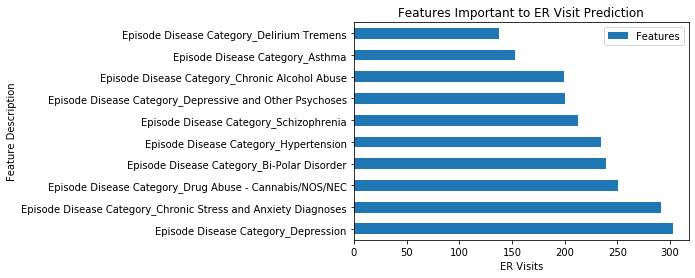

In [71]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X)
XT_train = ohe.transform(X_train)

model_rfrv_ = Ridge()
model_rfrv_.fit(XT_train, y_train)

slopes = pd.DataFrame(data=model_rfrv_.coef_, index=XT_train.columns, columns=['Features'])
slopes.abs().sort_values(by='Features', ascending=False).head(10).plot(kind='barh')
plt.title("Features Important to ER Visit Prediction")
plt.xlabel("ER Visits")
plt.ylabel("Feature Description")
plt.show()